In [1]:
import math
import random
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
class Model():
    
    def __init__(self, n_mun, dist = [0.1, 0.4, 0.3, 0.2]):
        """Model class has following input parameters
        1. n_mun: number of municipality
        2. n_com: number of company
        3. dist: population distribution (single, couple, family, retired)
        """
        self.n_mun = n_mun
        self.n_com = n_mun * 5 # for every municipality, 5 company will be matched
        self.dist = dist
        """
        Model class has following attributes:
        ticks: how much time has passed
        mun_dict: dictionary of municipality objects
        com_dict: dictionary of company objects
        requests: requests posted by Municipality
        offers: bid offers from Company
        """
        self.ticks = 0
        self.mun_dict = dict()
        self.com_dict = dict()
        self.demand = [0, 0]
        self.requests = []
        self.offers = []
        
    def populate(self):
        """Populate Municipalities
        2 parameters (n_pop, dist) determine how each municipality look like        
        1. n_pop: number of population
        2. dist: distribution ["single", "couple", "family", "retired"]"""
        for i in range(self.n_mun):
            """
            Population is between 75~500k,
            given 1) annual waste: 3k~20kTon and 2) 40kg per year per household
            """
            mul = 1
            n_pop = random.randint(75*mul, 500*mul)
            m = self.Municipality(i, n_pop, self.dist, self)
            # store into the dictionary
            self.mun_dict[i] = m           
        """Populate Companies"""
        for i in range(self.n_com):
            c = self.Company(i, self)
            # store into the dictionary
            self.com_dict[i] = c
            
    def update(self):
        """Before proceed, Contract has to be made in following orders:
        1. Municipality: Request -> 2. Company: Offer (Bid) -> 3. Municipality: Select"""
        
        # Municipality Requests
        self.contract_mun()
        if len(self.requests) != 0:
            self.requests = np.array(self.requests)
        # Company Offers
        self.contract_com()
        if len(self.offers) != 0:
            self.offers = pd.DataFrame(self.offers)
            
        # Municipality Selects and Closes bid
        self.select_mun()
        if len(self.requests) != 0:
            # Requests and Offers are initialized after bid closed
            self.requests = []
            self.offers = []
        
        """Update the model by proceeding time tick
        Each municipality step forward (and Households inside)"""
        self.update_mun()
        self.update_com()
        self.ticks += 1

    def contract_mun(self):
        # Municipalities RQ
        for i, mun in self.mun_dict.items():
            mun._check_contract()
            
    def contract_com(self):
        # Companies OFFER (bid)
        for i, com in self.com_dict.items():
            com._check_request()
    
    def select_mun(self):
        # Municipalities SELECT bidder
        for i, mun in self.mun_dict.items():
            mun._select()

    def update_mun(self):
        # Municipalities step forward
        for i, mun in self.mun_dict.items():
            mun._update()
            
    def update_com(self):
        # Companies step forward
        for i, com in self.com_dict.items():
            com._update()
            
    """COMPANY"""            
    class Company():
        
        def __init__(self, unique_id, model):
            self.unique_id = unique_id
            self.model = model
            
            self.contract_made = []
            self.have_contract = False
            self.contract_history = []
            
        def _check_request(self):
            """Check whether there is a request"""
            if len(self.model.requests) != 0:
                self.contract = True
                self._offer()
            else:
                self.contract = False
        
        def _offer(self):
            """Company makes an offer"""
            requests = self.model.requests
            request = requests[requests[:,0] == self.unique_id//5][0]
            # Read the requirments of Municipalities (volume and percent)
            mun_id = request[0]
            volume = request[1]
            percent = request[2]

            """Based on the volume and percent (posted on the requests), Company creates offer"""
            volume = random.gauss(volume, sigma = volume / 10)
            percent = random.gauss(percent, sigma = 0.01)
            bidprice = int(volume * percent)
            # Company suggests fine 5~10% of bidprice
            fine = int(bidprice * random.uniform(0.05, 0.10))
            
            # Create the bid package and post on the market (model)
            offer_key = ["mun_id", "vol", "perc", "bidprice", "fine", "com_id", "time"]
            offer_list = [self.unique_id//5, volume, percent, bidprice, fine, self.unique_id, self.model.ticks]
            self.model.offers.append(dict(zip(offer_key, offer_list)))
            
        def _update(self):
            if self.have_contract:
                self._fine()
                self._recover()
            else:
                pass
            
        def _fine(self):
            # Read Contract, Specify Municipality in Contract
            mun_id = self.contract_made["mun_id"]
            mun = self.model.mun_dict[mun_id]
            
            # Check Wastes from Municipality
            waste = mun._waste
            plastic = mun._plastic
            recycle = mun._recycle
            
            # Compare with Contract
            claim_fine = self.contract_made["vol"] > waste
            
            # Claim Fine
            if claim_fine:
                fine = self.contract_made["fine"]
            else:
                fine = 0
            # Notify to Municipality
            mun.fine_history[self.model.ticks] = self.unique_id, fine
            
        def _recover(self):
            print("com", self.unique_id, "recovers waste")
            print("=======================================")
            
    """MUNICIPALITY"""                
    class Municipality():
        
        def __init__(self, unique_id, n_pop, dist, model):
            """
            Municipality
            1. ID
            2. n_pop: Population
            3. dist: Distribution
            4. pop: Population Distribution (Dictionary object as a result of 2, 3)
            5. household_dict: Residents
            6. Model object (to easily access to the upper class variable)
            
            7. Waste History (Waste, Plastic, Recycle)
            
            (After update)
            8. (Sum) Waste
            9. (Sum) Plastic Waste
            10. (Sum) recyle
            
            11. target
            12. provider (waste service)
            13. acceptable fine (threshold)
            
            14. contract history
            15. fine history
            """
            self.unique_id = unique_id
            self.n_pop = n_pop
            self.dist = dist
            self.pop = np.array(dist) * n_pop
            self.household_dict = dict()
            self.model = model

            self.waste_history = []
            
            self._waste = 0
            self._plastic = 0
            self._recycle = 0

            """PARAMETERIZE"""
            self.target = 0.3 # this is given
            self.provider = 0
            self.fine_thresh = 7
            
            self.contract_history = []
            self.fine_history = dict()
            
            for i in range(self.n_pop):
                """When the municipality initializes,
                it automatically populate households inside"""
                # each house hold takes: ID, Municipal ID and Municipal object
                h = self.Household(i, self.unique_id, self)
                # Automatically Populate by the parameter: distribution (in order to decide type)
                h._populate(self.dist)
                # store inside the dictionary
                self.household_dict[i] = h
            
        def _check_contract(self):
            if self.model.ticks%36 == 1:
                self.contract = True
                self._request()
            else:
                self.contract = False
                
        def _request(self):
            """Municipality request offer"""
            if self.provider != 0:
                self._init_contracts()
            
            # We have X volumn, x% should be recycled
            X = self._waste
            x = self.target
            # Change the environment (Model)
            # Posting a Bid
            self.model.requests.append([self.unique_id, X,x])
            
        def _init_contracts(self):
            self.provider.contract_made = 0
            self.provider.have_contract = False
            
        def _select(self):
            if self.contract:
                """Municipality select offer and filter"""
                # 1.filter mun_id
                offers = self.model.offers[self.model.offers["mun_id"] == self.unique_id]
                
                # 2.filter volume
                # if all bids doesn't match, then there is no way. just accept
                vol_filter = offers["vol"] >= self._waste
                if len(vol_filter.nonzero()[0]) != 0:
                    offers = offers[vol_filter]
                
                # 3. filter percentage
                perc_filter = offers["perc"] >= self.target
                if len(perc_filter.nonzero()[0]) != 0:
                    offers = offers[perc_filter]
                
                # 4.filter fine
                fine_filter = offers["fine"] <= self.fine_thresh
                # if all bids doesn't match, then there is no way. just accept
                if len(fine_filter.nonzero()[0]) != 0:
                    offers = offers[fine_filter]

                # 5. finally select the cheapest bid
                min_ = (offers["bidprice"] + offers["fine"]).idxmin()
                offers = offers.loc[min_]
                self.contract_made = dict(offers)
                
                # 6. Announce to the company who wins
                winner = offers["com_id"]
                self.provider = self.model.com_dict[winner]
                self.provider.contract_made = dict(offers)
                self.provider.have_contract = True
                self.provider.contract_history.append(dict(offers))
                                
                # 7. Archive to its own storage
                self.contract_history.append(self.contract_made)
                
        def _update(self):
            
            self._waste = 0
            self._plastic = 0
            self._recycle = 0

            """When the municipality is updated,
            It forces every household to be updated"""
            for i, household in self.household_dict.items():
                household._update()
                # Sum up wastes from all households
                self._waste += household.waste
                self._plastic += household.plastic
                self._recycle += household.recycle
            self.waste_history.append([self._waste, self._plastic, self._recycle])
            
#         def _campaign(self):
#             """Promote the importance (more recycling) """
            
#         def _educate(self):
#             """Educate (better recycling) """
                    
        class Household():
            """Households are defined inside the Municipality Class"""            
            def __init__(self, unique_id, mun_id, mun_obj):
                """Household has following attributes:
                1. ID
                2. Municipal ID (where they belong to)
                3. Municipal object (for easy access to the upper class variables)
                
                (After Populate:)
                4. type ("single, couple, family, old")
                5. weights applied to the volumn of wastes
                6. access to facility
                7. perception and knowledge
                8. fraction of plastic in the waste and recyclable plastic in the plastic waste
                
                (After Update:)
                9. Wastes
                10. Plastic Wastes
                11. Recyclable wastes"""
                self.unique_id = unique_id
                self.mun_id = mun_id
                self.mun_obj = mun_obj
                
            def _populate(self, dist):
                # assign type
                r = random.random()
                id_ = np.where(np.array(dist).cumsum() > r)[0].min()
                self.type = ["0single", "1couple", "2family", "3retired"][id_]
                self.weight = [0.95, 1.05, 1.10, 0.90][id_]
                """PARAMETERIZE"""
                # assign access
                self.access = random.choice([True,False])
                # assign percept [0,1]
                self.percept = random.random()
                """PARAMETERIZE"""
                self.frac_p = self.percept
                # assign knowledge [0,1]
                self.knowledge = random.random()
                """PARAMETERIZE"""
                self.frac_r = self.knowledge
                
            def _update(self):
                self.ticks = self.mun_obj.model.ticks
                self._produce()

            def _produce(self):
                x = self.ticks
                self.waste = self.weight * (40 - 0.04 * x - math.exp(-0.01*x) * math.sin(0.3*x))/12
                self.plastic = self.waste * self.frac_p
                self.recycle = self.plastic * self.frac_r
model = Model(n_mun=3)
model.populate()

In [3]:
model.update()

Create a Model instance

1. 3 Municipalities (<code>n_mun=3</code>)
2. Populate (Municipalites, Households, Companies)
3. 100 step forward

In [4]:
model = Model(n_mun=3)
model.populate()
for i in range(100):
    model.update()

com 2 recovers waste
com 6 recovers waste
com 12 recovers waste
com 2 recovers waste
com 6 recovers waste
com 12 recovers waste
com 2 recovers waste
com 6 recovers waste
com 12 recovers waste
com 2 recovers waste
com 6 recovers waste
com 12 recovers waste
com 2 recovers waste
com 6 recovers waste
com 12 recovers waste
com 2 recovers waste
com 6 recovers waste
com 12 recovers waste
com 2 recovers waste
com 6 recovers waste
com 12 recovers waste
com 2 recovers waste
com 6 recovers waste
com 12 recovers waste
com 2 recovers waste
com 6 recovers waste
com 12 recovers waste
com 2 recovers waste
com 6 recovers waste
com 12 recovers waste
com 2 recovers waste
com 6 recovers waste
com 12 recovers waste
com 2 recovers waste
com 6 recovers waste
com 12 recovers waste
com 2 recovers waste
com 6 recovers waste
com 12 recovers waste
com 2 recovers waste
com 6 recovers waste
com 12 recovers waste
com 2 recovers waste
com 6 recovers waste
com 12 recovers waste
com 2 recovers waste
com 6 recovers wast

com 3 recovers waste
com 7 recovers waste
com 13 recovers waste
com 3 recovers waste
com 7 recovers waste
com 13 recovers waste
com 3 recovers waste
com 7 recovers waste
com 13 recovers waste
com 3 recovers waste
com 7 recovers waste
com 13 recovers waste
com 3 recovers waste
com 7 recovers waste
com 13 recovers waste
com 3 recovers waste
com 7 recovers waste
com 13 recovers waste
com 3 recovers waste
com 7 recovers waste
com 13 recovers waste
com 3 recovers waste
com 7 recovers waste
com 13 recovers waste
com 3 recovers waste
com 7 recovers waste
com 13 recovers waste
com 3 recovers waste
com 7 recovers waste
com 13 recovers waste
com 3 recovers waste
com 7 recovers waste
com 13 recovers waste
com 3 recovers waste
com 7 recovers waste
com 13 recovers waste
com 3 recovers waste
com 7 recovers waste
com 13 recovers waste
com 3 recovers waste
com 7 recovers waste
com 13 recovers waste
com 3 recovers waste
com 7 recovers waste
com 13 recovers waste
com 3 recovers waste
com 7 recovers wast

## 1. Resident in Municipality
    investigate one household who is living in municipality

In [5]:
# there are 3 municipalities
model.mun_dict

{0: <__main__.Model.Municipality at 0x1de0cafc9b0>,
 1: <__main__.Model.Municipality at 0x1de0cb278d0>,
 2: <__main__.Model.Municipality at 0x1de0cb8fdd8>}

In [6]:
# select one house hold
model.mun_dict[0].household_dict[0]

#### Type, Access, Perception, Knowledge, Waste (Total, Plastic, Recyclable), Weight

In [7]:
model.mun_dict[0].household_dict[0].type

'3retired'

In [8]:
model.mun_dict[0].household_dict[0].access

True

In [9]:
model.mun_dict[0].household_dict[0].percept

0.8697858411766276

In [10]:
model.mun_dict[0].household_dict[0].knowledge

0.9633216041278927

In [11]:
model.mun_dict[0].household_dict[0].waste

2.730575275215358

In [12]:
model.mun_dict[0].household_dict[0].plastic

2.3750157126492915

In [13]:
model.mun_dict[0].household_dict[0].recycle

2.2879039461382655

In [14]:
model.mun_dict[0].household_dict[0].weight

0.9

### Population Distribution in Municipality id = 0

(array([ 35.,   0.,   0., 131.,   0.,   0., 115.,   0.,   0.,  68.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

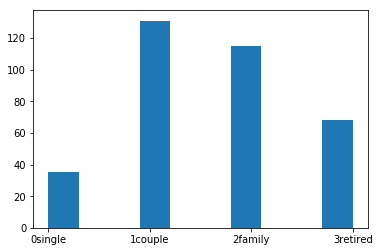

In [15]:
l=[]
for id_, household in model.mun_dict[0].household_dict.items():
    l.append(household.type)
l.sort()
plt.hist(l)

## 2. Waste Disposal over Time

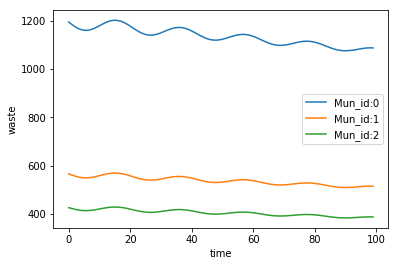

In [16]:
for id_, mun in model.mun_dict.items():
    waste_history = np.array(mun.waste_history)[:, 0]
    plt.plot(waste_history, label = "Mun_id:%s"%mun.unique_id)
plt.ylabel("waste")
plt.xlabel("time")
plt.legend()

## 3. Contracts

#### Municipality (id = 0) has made 3 contracts so far
it specifies 5 variables:

    mun_id, com_id, bidprice, fine, volume(X) and percentage(x)

In [17]:
pd.DataFrame(model.mun_dict[1].contract_history)

,bidprice,com_id,fine,mun_id,perc,time,vol
0,171.0,6.0,15.0,1.0,0.300367,1.0,572.176049
1,169.0,6.0,13.0,1.0,0.298105,37.0,570.063296
2,152.0,7.0,15.0,1.0,0.281842,73.0,539.352269


#### Each Company also have a corresponding contract

In [18]:
for contract in model.mun_dict[1].contract_history:
    winner = contract["com_id"]
    print(model.com_dict[winner].contract_history)

[{'bidprice': 171.0, 'com_id': 6.0, 'fine': 15.0, 'mun_id': 1.0, 'perc': 0.30036706267148916, 'time': 1.0, 'vol': 572.1760487296333}, {'bidprice': 169.0, 'com_id': 6.0, 'fine': 13.0, 'mun_id': 1.0, 'perc': 0.29810462680542016, 'time': 37.0, 'vol': 570.0632961184137}]
[{'bidprice': 171.0, 'com_id': 6.0, 'fine': 15.0, 'mun_id': 1.0, 'perc': 0.30036706267148916, 'time': 1.0, 'vol': 572.1760487296333}, {'bidprice': 169.0, 'com_id': 6.0, 'fine': 13.0, 'mun_id': 1.0, 'perc': 0.29810462680542016, 'time': 37.0, 'vol': 570.0632961184137}]
[{'bidprice': 152.0, 'com_id': 7.0, 'fine': 15.0, 'mun_id': 1.0, 'perc': 0.281841832979959, 'time': 73.0, 'vol': 539.3522690005659}]
